In [3]:
%matplotlib widget
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util import *
from amftrack.notebooks.post_processing.util import *
import pickle
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, save_graphs, load_graphs
from amftrack.plotutil import plot_t_tp1, plot_node_skel
import imageio
from amftrack.pipeline.functions.image_processing.experiment_class_surf import plot_raw_plus,find_node_equ, get_distance



In [4]:
directory = directory_project
update_analysis_info(directory)
analysis_info = get_analysis_info(directory)
select = analysis_info

In [5]:
num = 9
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    print(index,row["Plate"])
    try:
        a = np.load(f'{path}/center.npy')
    except:
        print(index,row["Plate"])
    if index == num:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

0 799
1 790
2 792
3 800
4 22
4 22
5 80
6 10
7 76
8 102
9 94


In [6]:
load_graphs(exp,indexes = range(98,100))


In [204]:
end = 1
hyph_label = end
hyph= [hyph for hyph in exp.hyphaes if hyph.end.label == end][0]


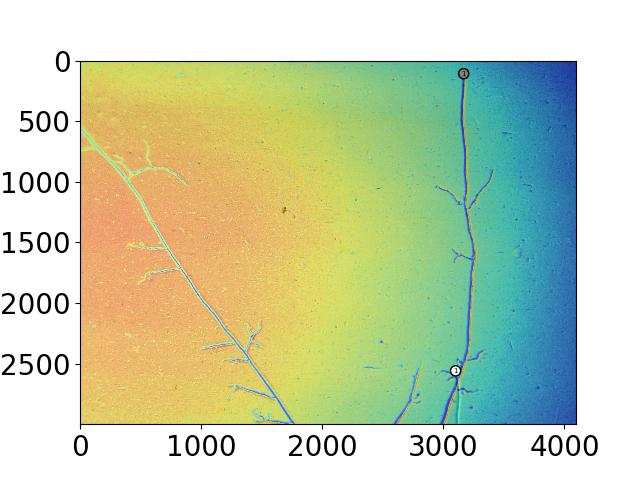

In [208]:
plt.close('all')
init = hyph.ts[0]+22
hyph.end.show_source_image(init,init+1)

In [7]:
list_hyph = np.load('hyph_interest.npy',allow_pickle=True)


In [258]:
list_hyph

array([ 7424, 37760,     0,  1027,     1,  1670, 14599, 18054, 36105,
       54793,   139,  9612, 45706, 52745,    19,    20,  9620, 10389,
       19731, 36632, 24473, 67098,  7452, 11934,  6178, 32548,   164,
        7463, 28328, 24489,  4650, 62889, 17325, 25519,  2607, 57138,
       47668,    56, 31802, 19004, 29500,  9150, 22207, 64831, 44026,
       29123, 63299, 24901,  9418, 62667, 41036, 67023,  6992, 18897,
       26705, 54611, 59092,  4309,  6743, 73056, 58477,  8690, 57075,
       20212, 37749, 73843, 10617, 10106, 69245, 14590], dtype=int32)

In [8]:
%%time
# list_hyph = [164,6992,24489,9150,18897,7424,18054,9612,22207,56,1]
list_hyph = np.load('hyph_interest.npy',allow_pickle=True)

# list_hyph = [11934]
actual_list_hyph = []
for end in list_hyph:
    hyph_label = end
    hyph= [hyph for hyph in exp.hyphaes if hyph.end.label == end][0]
    t0 = hyph.ts[0]
    exp = hyph.experiment
    thresh = 1600
    junctions_found= [hyph.end.neighbours(t0)[0]]
    ts = []
    mult = []
    print(end)
    for t in hyph.ts:
        try:
            G = exp.nx_graph[t]
            G = G.subgraph(nx.node_connected_component(G, hyph.end.label))
            if hyph.end.degree(t)==1:
                nodes,edges = hyph.get_nodes_within(t)
                potentials = []
                nodes = [Node(node,exp) for node in nodes]
                try:
                    last_junction_index = nodes.index(junctions_found[-1])
                except:
                    last_junction_index =0 
                for node in nodes[last_junction_index+1:-1]:
                    dist = np.linalg.norm(node.pos(t)-hyph.end.pos(t))
                    #To avoid detecting two times the same  node with different labels
                    dists_junction_found = [np.inf]+[np.linalg.norm(node.pos(t)-nodo.pos(t)) for nodo in junctions_found if nodo.is_in(t)] 
                    if dist<thresh and min(dists_junction_found)>40 and(node not in junctions_found):
                        extra_hypha_neighbours = [nodo for nodo in node.neighbours(t) if nodo not in nodes]
                        tips = [nodo for nodo in extra_hypha_neighbours if nx.edge_connectivity(G,nodo.label,node.label)==1]
                        if len(tips) == node.degree(t)-2:
                            junctions_found.append(node)  
                            mult.append(node.degree(t)-2)
                            ts.append(t)
        except nx.exception.NetworkXNoPath:
            print(hyph,t)

    tf = 99
    junctions_found_tf  = [find_node_equ(node,tf) for node in junctions_found]
    junctions_found_label  = [node.label for node in junctions_found_tf]
    t_real = [get_time(exp,t0,t) for t in ts]
    try:
        distances = [get_distance(junctions_found_tf[i],junctions_found_tf[i+1],tf) for i in range(1,len(junctions_found_tf)-1)]
        np.save(f'branches/ts_{hyph_label}_auto',t_real)
        np.save(f'branches/distances_{hyph_label}_auto',distances)
        actual_list_hyph.append(end)
    except nx.exception.NetworkXNoPath:
        print('problem with',end)
        


7424


TypeError: get_time() missing 1 required positional argument: 'args'

In [266]:
actual_list_hyph

[7424,
 37760,
 0,
 1027,
 1,
 1670,
 14599,
 18054,
 36105,
 54793,
 139,
 9612,
 45706,
 52745,
 19,
 20,
 9620,
 10389,
 19731,
 36632,
 24473,
 67098,
 7452,
 32548,
 164,
 7463,
 28328,
 24489,
 4650,
 62889,
 17325,
 25519,
 57138,
 47668,
 56,
 31802,
 19004,
 9150,
 22207,
 64831,
 44026,
 29123,
 63299,
 24901,
 9418,
 62667,
 41036,
 67023,
 6992,
 18897,
 26705,
 54611,
 59092,
 4309,
 6743,
 73056,
 58477,
 57075,
 20212,
 37749,
 73843,
 10617,
 69245]

In [9]:
zipObj = ZipFile('branches.zip', 'w')
for end in actual_list_hyph:
    zipObj.write(f'branches/ts_{end}_auto.npy')
    zipObj.write(f'branches/distances_{end}_auto.npy')
zipObj.close()

NameError: name 'ZipFile' is not defined

In [268]:
np.save('actual_list_hyph',actual_list_hyph)

In [238]:
from zipfile import ZipFile

In [225]:
len(exp.hyphaes)

4199

In [210]:
tf = 99
junctions_found_tf  = [find_node_equ(node,tf) for node in junctions_found]
junctions_found_label  = [node.label for node in junctions_found_tf]

In [17]:
def find_hyph_root(exp,node,t):
    for hypha in exp.hyphaes:
        if hypha.get_root(t)==node:
            return(hypha)
    return(None)

In [28]:
hyphs = [find_hyph_root(exp,node,tf) for node in junctions_found_tf]

In [33]:
hyphs

[Hyphae(6992,6994),
 Hyphae(11121,11122),
 Hyphae(13938,13939),
 Hyphae(14595,14597),
 None,
 Hyphae(19731,19733),
 Hyphae(21561,21565),
 Hyphae(26609,26610),
 Hyphae(27883,27884),
 Hyphae(34660,34666),
 Hyphae(36118,36121),
 Hyphae(52785,37599),
 Hyphae(45722,45724),
 Hyphae(50984,50985),
 Hyphae(56480,56481),
 Hyphae(58477,58480),
 Hyphae(73843,73844),
 Hyphae(81166,81165),
 Hyphae(86112,86115),
 Hyphae(96541,96544),
 Hyphae(115356,115363)]

In [38]:
hyphs_branch = [hyph for hyph in hyphs if not hyph is None]

In [45]:
hyphs_branch[-3]

Hyphae(86112,86115)

In [43]:
lengths = [hyph.get_length_um(tf) for hyph in hyphs_branch]

NetworkXNoPath: No path to 11121.

In [1]:
plt.close('all')
junctions_found_tf  = [find_node_equ(node,tf) for node in junctions_found]
junctions_found_label  = [node.label for node in junctions_found_tf]
plot_raw_plus(exp,tf,junctions_found_label)

NameError: name 'plt' is not defined

In [212]:
t_real = [get_time(exp,t0,t) for t in ts]

In [213]:
np.save(f'ts_{hyph_label}',t_real)

In [215]:
junctions_found_tf

[Node(17),
 Node(128847),
 Node(676),
 Node(90424),
 Node(2435),
 Node(5039),
 Node(6181),
 Node(6181),
 Node(7417),
 Node(8691),
 Node(9151),
 Node(89665),
 Node(12807),
 Node(15856),
 Node(19720),
 Node(23470),
 Node(25513),
 Node(26598),
 Node(33206),
 Node(34653),
 Node(36106),
 Node(40831),
 Node(45707),
 Node(60537),
 Node(54605),
 Node(58467),
 Node(67024),
 Node(69246),
 Node(83605),
 Node(101711),
 Node(112649),
 Node(115341)]

In [216]:
distances = [get_distance(junctions_found_tf[i],junctions_found_tf[i+1],tf) for i in range(2,len(junctions_found_tf)-1)]

In [26]:
np.mean(distances)

1037.038734224214

Text(0.5, 0, 'time since emergence')

Text(0, 0.5, 'distance between successive branching points ($\\mu m$)')

Text(0.5, 1.0, 'hyph 1')

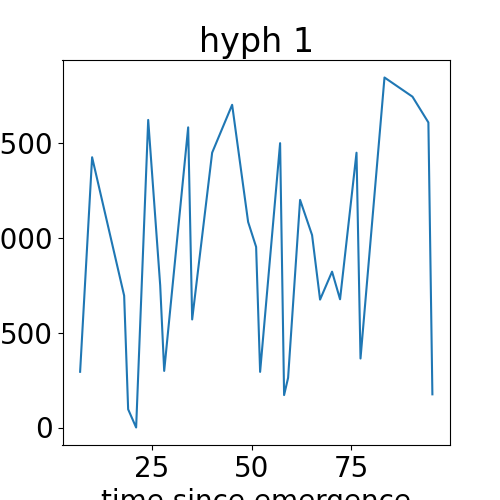

In [220]:
plt.close('all')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(t_real[2:],distances)
ax.set_xlabel('time since emergence')
ax.set_ylabel('distance between successive branching points ($\mu m$)')
ax.set_title(f'hyph {hyph.end}')


In [129]:
get_distance(junctions_found_tf[1],junctions_found_tf[2],99)

1525.8271813862123

In [125]:
list(range(99,100))

[99]

In [121]:
exp.nx_graph[99].get_edge_data(25771,13939)

{'weight': 894, 'pixel_list': None, 'width': 10.050086250557547}

In [12]:
hyph = choice(exp.hyphaes)
hyph.ts

[74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [32]:
hyph.ts

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [39]:
def make_video_node(node,t0,t1,anchor = None):
    for t in range(t0,t1):
        save=f'Figure/im**{t}'
        plot_node_skel(node,t,save = save, anchor =anchor,anchor_time_display = t0)
    img_array = []
    for t in range(t0,t1):
        img = cv2.imread(f'Figure/im**{t}.png')
        height, width, layers = img.shape
        size = (width,height)
        ratio = 1.5 
        print(int(ratio*get_time(exp,t,t+1)))
        for i in range(int(ratio*get_time(exp,t,t+1))):
            img_array.append(img)
    imageio.mimsave(f'Figure/{node.experiment.plate}_{node.label}.mp4', img_array)

In [ ]:
make_video_node(hyph.end,64,72)

findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.


In [16]:
def get_time(exp,t,tp1):#redefined here to avoid loop in import
    seconds = (exp.dates[tp1]-exp.dates[t]).total_seconds()
    return(seconds/3600)
def plot_node_skel(node,t0,ranges = 1000,save='',anchor = None,anchor_time_display = 0):
    t = t0
    exp = node.experiment
    anchor_time = t0 if (anchor is None) else anchor
    center = node.pos(anchor_time)[1],node.pos(anchor_time)[0]
    window = (center[0]-ranges,center[0]+ranges,center[1]-ranges,center[1]+ranges)
    skelet,rot,trans = get_skeleton(node.experiment,window,t,node.experiment.directory)
#     im_stitched = get_im_stitched(exp,window,t,directory)
    tips = [node.label for node in exp.nodes if t in node.ts() and node.degree(t) ==1 and node.pos(t)[1]>=window[0] and node.pos(t)[1]<=window[1] and node.pos(t)[0]>=window[2] and node.pos(t)[0]<=window[3]]
    junction =  [node.label for node in exp.nodes if t in node.ts() and node.degree(t) >=2 and node.pos(t)[1]>=window[0] and node.pos(t)[1]<=window[1] and node.pos(t)[0]>=window[2] and node.pos(t)[0]<=window[3]]
    _ = plot_t_tp1(junction,tips,exp.positions[t],exp.positions[t],skelet,skelet,shift=(window[2],window[0]),save = save, time=f't={int(get_time(exp,anchor_time_display,t))}h')